Setup

In [137]:
import json
import math
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt

BENCHMARK_PATH = Path('').resolve().parent / 'benchmark'
RESULTS_PATH = BENCHMARK_PATH / 'results.json'
assert RESULTS_PATH.exists()

Process data into DataFrames

In [138]:
results = json.load(open(RESULTS_PATH))
benchmarks = results['benchmarks']
context = {
    'ClMatMul':
        json.loads(results['context']['ClMatMul']),
    'ClMatMulComputeUnits':
        json.loads(results['context']['ClMatMulComputeUnits']),
    }
eigen = []
opencl = []
for b in benchmarks:
    if b.get('errors_ocurred', False):
        continue
    run = b['name'].split('/')
    test_name = run[0]
    test_suite = run[1]
    if test_suite == 'Eigen':
        eigen.append({
            'work': int(run[2]),
            'time': b['real_time'],
            'cpu_time': b['cpu_time'],
            })
    elif test_suite == 'OpenCL':
        device = context[test_name]['devices'][int(run[3])]['name']
        opencl.append({
            'work': int(run[2]),
            'device': device,
            'compute_units': int(run[4]) if len(run) > 4 else None,
            'time': b['real_time'],
            'cpu_time': b['cpu_time'],
            })
eigen = pd.DataFrame(eigen)
eigen['speed'] = eigen['work'] / eigen['time'] * 1000
opencl = pd.DataFrame(opencl)
opencl['speed'] = opencl['work'] / opencl['time'] * 1000
print(eigen.head())
print(opencl.head())

   work      time  cpu_time         speed
0   256  0.000552  0.000544  4.638967e+08
1   512  0.001445  0.001444  3.542871e+08
2  1024  0.002995  0.002982  3.418545e+08
3  2048  0.007937  0.008022  2.580411e+08
4  4096  0.020813  0.020856  1.967988e+08
   work                     device  compute_units      time  cpu_time  \
0   256  Intel(R) UHD Graphics 630            NaN  0.231241  0.224933   
1   512  Intel(R) UHD Graphics 630            NaN  0.249740  0.245857   
2  1024  Intel(R) UHD Graphics 630            NaN  0.275428  0.279018   
3  2048  Intel(R) UHD Graphics 630            NaN  0.311085  0.313895   
4  4096  Intel(R) UHD Graphics 630            NaN  0.398623  0.399013   

          speed  
0  1.107072e+06  
1  2.050133e+06  
2  3.717844e+06  
3  6.583412e+06  
4  1.027537e+07  


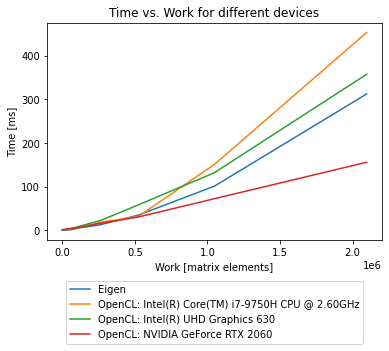

In [139]:
ax = eigen.plot(
    x='work',
    y='time',
    label='Eigen',
    )
for name, group in opencl[opencl['compute_units'].isnull()].groupby('device'):
    group.plot(x='work', y='time', label=f"OpenCL: {name}", ax=ax)
ax.set_title('Time vs. Work for different devices')
ax.set_xlabel('Work [matrix elements]')
ax.set_ylabel('Time [ms]')
ax.figure.savefig(
    BENCHMARK_PATH / "time-work.png",
    bbox_extra_artists=(
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5)),
        ),
    bbox_inches='tight'
    )
None

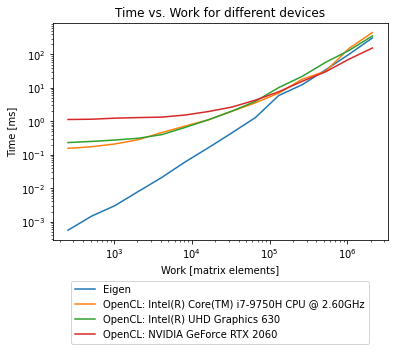

In [140]:
ax = eigen.plot(
    x='work',
    y='time',
    label='Eigen',
    )
for name, group in opencl[opencl['compute_units'].isnull()].groupby('device'):
    group.plot(x='work', y='time', label=f"OpenCL: {name}", ax=ax)
ax.set_title('Time vs. Work for different devices')
ax.set_xlabel('Work [matrix elements]')
ax.set_ylabel('Time [ms]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.figure.savefig(
    BENCHMARK_PATH / "time-work-log.png",
    bbox_extra_artists=(
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5)),
        ),
    bbox_inches='tight'
    )
None

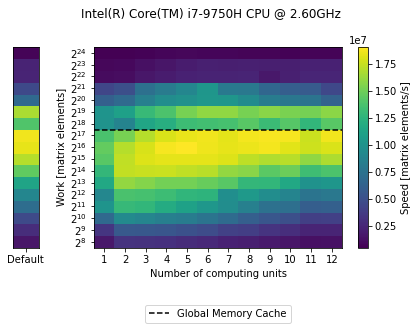

In [141]:
for index, (name, group) in enumerate(
    opencl[~opencl['compute_units'].isnull()].groupby('device')
    ):
    group['compute_units'] = group['compute_units'].astype(int)
    group['worklog2'] = group['work'].apply(math.log2).astype(int)
    fig, axs = plt.subplots(
        1, 2, gridspec_kw={'width_ratios': [1, group['compute_units'].max()]}
        )
    mask = group['compute_units'] > 0
    colorbars = []
    for i, ax in enumerate(axs):
        data = pd.pivot_table(
            group[mask if i else ~mask],
            index='worklog2',
            columns='compute_units',
            values='speed'
            )
        plot = ax.pcolor(data)
        colorbars.append(
            fig.colorbar(plot, ax=ax, label='Speed [matrix elements/s]')
            )
        if i:
            ax.set_ylabel('Work [matrix elements]')
            ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
            ax.set_yticklabels(
                data.index.map(lambda x: f"$2^{{{x}}}$"), minor=False
                )
            ax.set_xlabel('Number of computing units')
            ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
            ax.set_xticklabels(data.columns, minor=False)
            # Print some horizontal lines
            for key, name, ls in [
                # ('max_work_group_size', 'Max Work Group Size', '-.'),
                # ('local_mem_size', 'Local Memory', '-'),
                ('global_mem_cache_size', 'Global Memory Cache', '--'),
                ]:
                worklog2 = math.log2(
                    context['ClMatMulComputeUnits']['devices'][index][key]
                    )
                ax.axhline(
                    y=worklog2 - data.index[0], color='k', ls=ls, label=name
                    )
        else:
            ax.set_yticks([])
            ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
            ax.set_xticklabels(["Default"], minor=False)
        # put the major ticks at the middle of each cell
    colorbars[0].mappable.set_clim(*colorbars[1].mappable.get_clim())
    colorbars[0].remove()
    fig.suptitle(device)
    fig.tight_layout()
    fig.savefig(
        BENCHMARK_PATH / f"d{index}-speed-units.png",
        bbox_extra_artists=(
            axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.4)),
            ),
        bbox_inches='tight'
        )

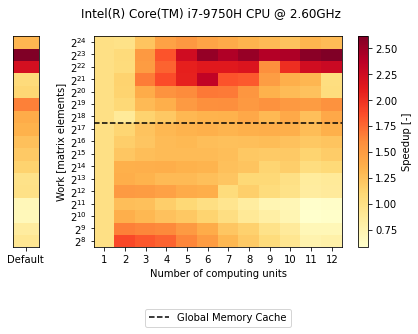

In [142]:
for index, (name, group) in enumerate(
    opencl[~opencl['compute_units'].isnull()].groupby('device')
    ):
    group['compute_units'] = group['compute_units'].astype(int)
    group['worklog2'] = group['work'].apply(math.log2).astype(int)
    fig, axs = plt.subplots(
        1, 2, gridspec_kw={'width_ratios': [1, group['compute_units'].max()]}
        )
    group['speedup'] = group.apply(
        lambda r: r['speed'] / group[
            (group['work'] == r['work']) &
            (group['compute_units'] == 1)]['speed'].item(),
        axis=1
        )
    mask = group['compute_units'] > 0
    colorbars = []
    for i, ax in enumerate(axs):
        data = pd.pivot_table(
            group[mask if i else ~mask],
            index='worklog2',
            columns='compute_units',
            values='speedup'
            )
        plot = ax.pcolor(data, cmap='YlOrRd')
        colorbars.append(
            fig.colorbar(plot, ax=ax, label='Speedup [-]')
            )
        if i:
            ax.set_ylabel('Work [matrix elements]')
            ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
            ax.set_yticklabels(
                data.index.map(lambda x: f"$2^{{{x}}}$"), minor=False
                )
            ax.set_xlabel('Number of computing units')
            ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
            ax.set_xticklabels(data.columns, minor=False)
            # Print some horizontal lines
            for key, name, ls in [
                # ('max_work_group_size', 'Max Work Group Size', '-.'),
                # ('local_mem_size', 'Local Memory', '-'),
                ('global_mem_cache_size', 'Global Memory Cache', '--'),
                ]:
                worklog2 = math.log2(
                    context['ClMatMulComputeUnits']['devices'][index][key]
                    )
                ax.axhline(
                    y=worklog2 - data.index[0], color='k', ls=ls, label=name
                    )
        else:
            ax.set_yticks([])
            ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
            ax.set_xticklabels(["Default"], minor=False)
        # put the major ticks at the middle of each cell
    colorbars[0].mappable.set_clim(*colorbars[1].mappable.get_clim())
    colorbars[0].remove()
    fig.suptitle(device)
    fig.tight_layout()
    fig.savefig(
        BENCHMARK_PATH / f"d{index}-speed-units.png",
        bbox_extra_artists=(
            axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.4)),
            ),
        bbox_inches='tight'
        )

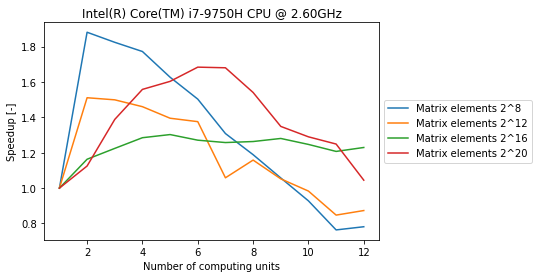

In [143]:
for index, (name, group) in enumerate(
    opencl[~opencl['compute_units'].isnull()].groupby('device')
    ):
    _, ax = plt.subplots()
    for work, data in group.groupby('work'):
        if (worklog2:=math.log2(work)) not in [8, 12, 16, 20]:
            continue
        data['speedup'] = data['speed'] / int(
            data[data['compute_units'] == 1]['speed']
            )
        data[data['compute_units'] > 0].plot(
            x='compute_units',
            y='speedup',
            label=f"Matrix elements 2^{worklog2:.0f}",
            ax=ax
            )
    ax.set_title(device)
    ax.set_xlabel("Number of computing units")
    ax.set_ylabel("Speedup [-]")
    ax.figure.savefig(
        BENCHMARK_PATH / f"d{index}-speedup-units-line.png",
        bbox_extra_artists=(
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)),
            ),
        bbox_inches='tight'
        )
